# Intro

I'm trying to learn the very basics with this exercise. My goal is to train a linear regression model with a subset of columns from this interesting dataset in order to predict the value of a used car.

Any help or advice is welcome!!!

### Changelist

* better study on the data
* used seaborn to plot
* added random forest and xgboost algorithms

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model, preprocessing, svm
from sklearn.preprocessing import StandardScaler, Normalizer
import math
import matplotlib
import seaborn as sns


# Preparing data

## Reading from file

Just reading the file and printing some lines.

In [2]:
df = pd.read_csv('autos.csv.gz', sep=',', header=0, compression='gzip',encoding='cp1252')
df.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


## Cleaning data from outliers and dirty values

Cleaning data from duplicates, NaNs and selecting reasonable ranges for columns


In [1]:
print("Too new: %d" % df.loc[df.yearOfRegistration >= 2017].count()['name'])
print("Too old: %d" % df.loc[df.yearOfRegistration < 1950].count()['name'])
print("Too cheap: %d" % df.loc[df.price < 100].count()['name'])
print("Too expensive: " , df.loc[df.price > 150000].count()['name'])
print("Too few km: " , df.loc[df.kilometer < 5000].count()['name'])
print("Too many km: " , df.loc[df.kilometer > 200000].count()['name'])
print("Too few PS: " , df.loc[df.powerPS < 10].count()['name'])
print("Too many PS: " , df.loc[df.powerPS > 500].count()['name'])
print("Fuel types: " , df['fuelType'].unique())
print("Offer types: " , df['offerType'].unique())
print("Sellers: " , df['seller'].unique())
print("Damages: " , df['notRepairedDamage'].unique())
print("Pics: " , df['nrOfPictures'].unique()) # nrOfPictures : number of pictures in the ad (unfortunately this field contains everywhere a 0 and is thus useless (bug in crawler!) )
print("Postale codes: " , df['postalCode'].unique())
print("Vehicle types: " , df['vehicleType'].unique())
print("Brands: " , df['brand'].unique())

#print("tourans: " , df[df['model']=='touran'][['name','vehicleType','powerPS','yearOfRegistration']])

# Cleaning data
valid_models = df.dropna()

#### Removing the duplicates
dedups = valid_models.drop_duplicates(['name','seller','offerType','price','abtest','vehicleType','yearOfRegistration'
                         ,'gearbox','powerPS','model','kilometer','monthOfRegistration','fuelType'
                         ,'notRepairedDamage','postalCode'])

#### Removing the outliers
no_outliers = dedups[
        (valid_models.yearOfRegistration <= 2016) 
      & (valid_models.yearOfRegistration >= 1950) 
      & (valid_models.price >= 100) 
      & (valid_models.price <= 150000) 
      & (valid_models.powerPS >= 10) 
      & (valid_models.powerPS <= 500)]

print("\nData kept for analisys: %d percent of the entire set" % (100 * no_outliers['name'].count() / df['name'].count()))

NameError: name 'df' is not defined

## Studying correlations between some features and sell price

I want to see how data is distributed and how it's related to the sell price. I start considering the numeric fields already present in the dataset, then I'll do other studies after having encoded the string fields.

(0, 160000)

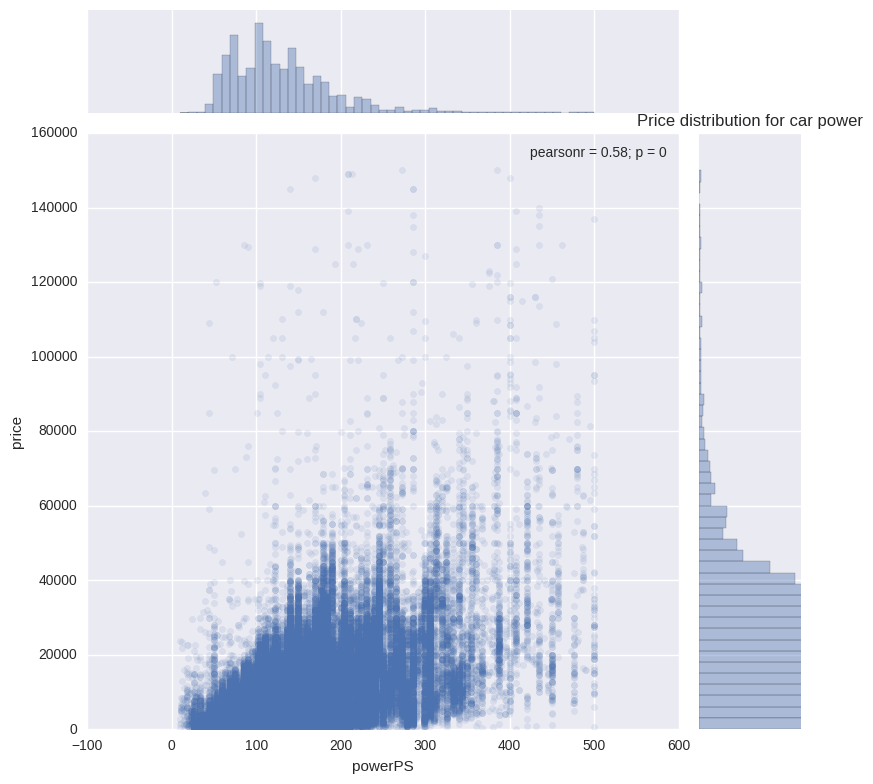

In [4]:
p = no_outliers
#plt.scatter(p['powerPS'], p['price'], alpha=.1, marker='o', color='b')
ax = sns.jointplot(x='powerPS', y='price',data=p[['powerPS','price']], alpha=0.1, size=8)
plt.title('Price distribution for car power')
#plt.xlabel('Power in HP')
#plt.ylabel('Price (logarithmic)')
#plt.yscale('log')

plt.xlim(0, 501)
plt.ylim(0, 160000)



Price at varying yearOfRegistration

(0, 160000)

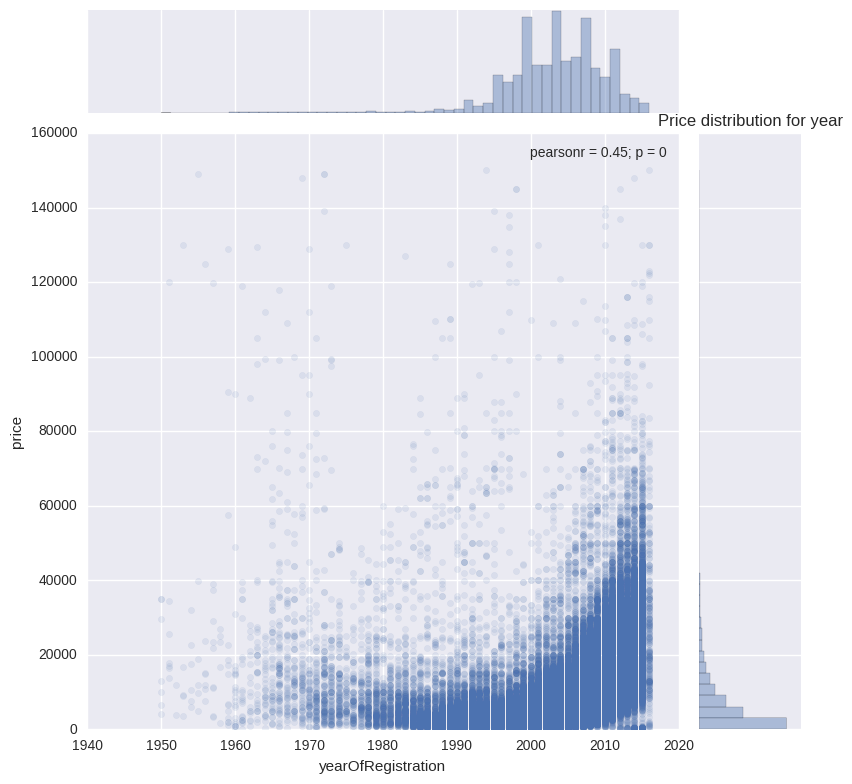

In [5]:
p = no_outliers
#plt.scatter(p['yearOfRegistration'], p['price'], alpha=.1, marker='o', color='b')
ax = sns.jointplot(x='yearOfRegistration', 
                   y='price',
                   data=p[['yearOfRegistration','price']], 
                   alpha=0.1, size=8)

plt.title('Price distribution for year')
#plt.xlabel('Year')
#plt.ylabel('Price (logarithmic)')
#plt.yscale('log')

plt.ylim(0, 160000)



Price at varying kilometers

([<matplotlib.axis.XTick at 0x7f277d15a978>,
 <a list of 13 Text xticklabel objects>)

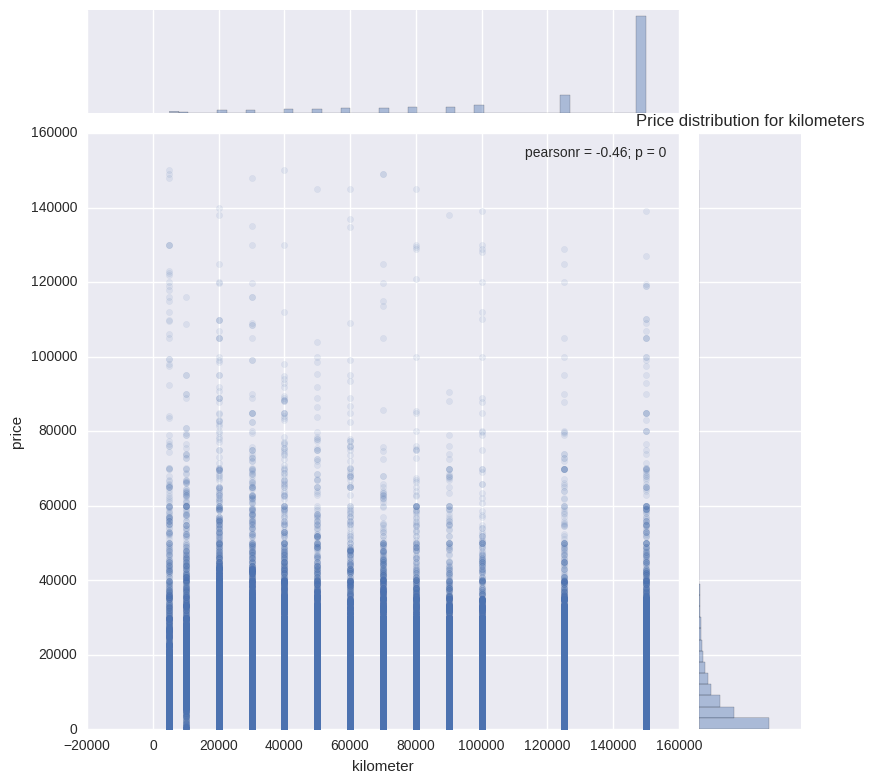

In [6]:
p = no_outliers
#plt.scatter(p['kilometer'], p['price'], alpha=.1, marker='o', color='b')
ax = sns.jointplot(x='kilometer', y='price',data=p[['kilometer','price']], alpha=0.1, size=8)

plt.title('Price distribution for kilometers')
#plt.xlabel('Kilometers')
#plt.ylabel('Price (logarithmic)')
#plt.yscale('log')
plt.ylim(0, 160000)
plt.xticks([5000,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,125000,150000], rotation='vertical')


## Selecting only relevant columns

Here I select the columns that I think are useful for determining a car's price.


In [7]:

# only relevant columns
rel_cols = no_outliers[['price'
                        ,'yearOfRegistration'
                        ,'gearbox'
                        ,'powerPS'
                        ,'model'
                        ,'kilometer'
                        ,'fuelType'
                        ,'vehicleType'
                        ,'monthOfRegistration'
                        ,'brand'
                        ,'notRepairedDamage']]
rel_cols.head()

,price,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,vehicleType,monthOfRegistration,brand,notRepairedDamage
3,1500,2001,manuell,75,golf,150000,benzin,kleinwagen,6,volkswagen,nein
4,3600,2008,manuell,69,fabia,90000,diesel,kleinwagen,7,skoda,nein
5,650,1995,manuell,102,3er,150000,benzin,limousine,10,bmw,ja
6,2200,2004,manuell,109,2_reihe,150000,benzin,cabrio,8,peugeot,nein
10,2000,2004,manuell,105,3_reihe,150000,benzin,limousine,12,mazda,nein


## Encoding

This part encodes the string fields to numerical values, in order to study the rest of the columns and to make some regressions.

In [8]:
labels = ['gearbox', 'notRepairedDamage', 'model', 'brand', 'fuelType', 'vehicleType']
les = {}

for l in labels:
    les[l] = preprocessing.LabelEncoder()
    les[l].fit(rel_cols[l])
    #print(les[l].classes_)
    tr = les[l].transform(rel_cols[l]) 
    rel_cols.loc[:, l + '_feat'] = pd.Series(tr, index=rel_cols.index)

df_autos = rel_cols[ ['price'
                        ,'yearOfRegistration'
                        ,'powerPS'
                        ,'kilometer'
                        ,'monthOfRegistration'] 
                    + [x+"_feat" for x in labels]]
autos = df_autos.values.astype(float)

Y = autos[:,0]
X = autos[:,1:]


/opt/conda/lib/python3.5/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Studying the other correlations

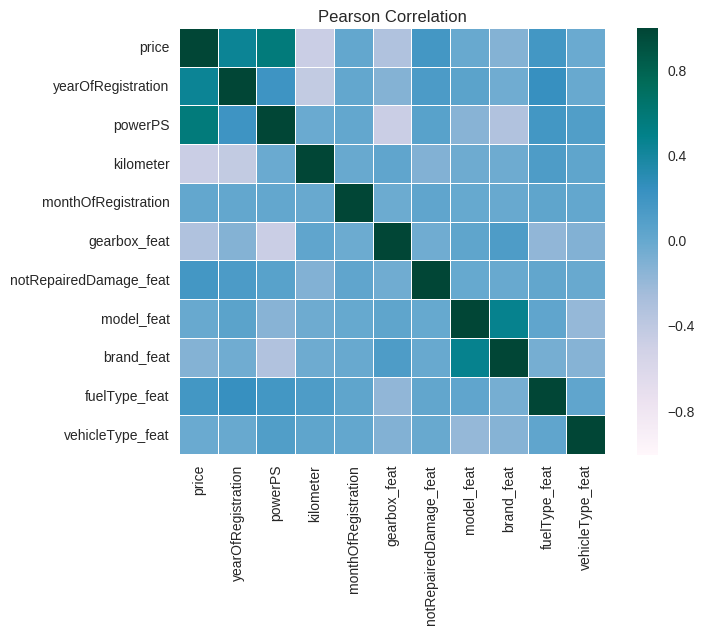

In [9]:
plt.title('Pearson Correlation')
sns.heatmap(df_autos.astype(float).corr(),
            linewidths=0.1,
            vmax=1.0, 
            square=True, 
            cmap="PuBuGn", 
            linecolor='w', 
            annot=False)


brands:  (0, 'alfa_romeo') (1, 'audi') (2, 'bmw') (3, 'chevrolet') (4, 'chrysler') (5, 'citroen') (6, 'dacia') (7, 'daewoo') (8, 'daihatsu') (9, 'fiat') (10, 'ford') (11, 'honda') (12, 'hyundai') (13, 'jaguar') (14, 'jeep') (15, 'kia') (16, 'lada') (17, 'lancia') (18, 'land_rover') (19, 'mazda') (20, 'mercedes_benz') (21, 'mini') (22, 'mitsubishi') (23, 'nissan') (24, 'opel') (25, 'peugeot') (26, 'porsche') (27, 'renault') (28, 'rover') (29, 'saab') (30, 'seat') (31, 'skoda') (32, 'smart') (33, 'subaru') (34, 'suzuki') (35, 'toyota') (36, 'trabant') (37, 'volkswagen') (38, 'volvo')


(0, 160000)

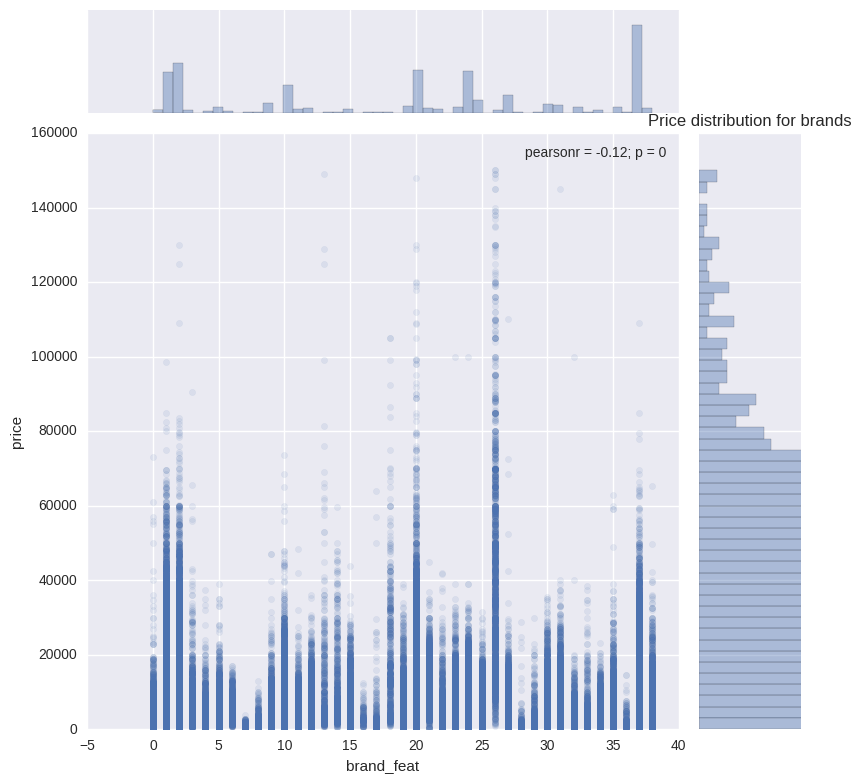

In [10]:
p = df_autos
#plt.scatter(p['powerPS'], p['price'], alpha=.1, marker='o', color='b')
ax = sns.jointplot(x='brand_feat', y='price',data=p[['brand_feat','price']], alpha=0.1, size=8)
plt.title('Price distribution for brands')
#plt.xlabel('Power in HP')
#plt.ylabel('Price (logarithmic)')
#plt.yscale('log')

brands = zip(range(0, len(les['brand'].classes_)), les['brand'].classes_)

s = ''
for b in brands:
    s = s + ' ' + str(b)

print("brands: " + s)

plt.xlim(0, 41)
plt.ylim(0, 160000)

models:  (0, '100') (1, '145') (2, '147') (3, '156') (4, '159') (5, '1_reihe') (6, '1er') (7, '200') (8, '2_reihe') (9, '300c') (10, '3_reihe') (11, '3er') (12, '4_reihe') (13, '500') (14, '5_reihe') (15, '5er') (16, '601') (17, '6_reihe') (18, '6er') (19, '7er') (20, '80') (21, '850') (22, '90') (23, '900') (24, '9000') (25, '911') (26, 'a1') (27, 'a2') (28, 'a3') (29, 'a4') (30, 'a5') (31, 'a6') (32, 'a8') (33, 'a_klasse') (34, 'accord') (35, 'agila') (36, 'alhambra') (37, 'almera') (38, 'altea') (39, 'amarok') (40, 'andere') (41, 'antara') (42, 'arosa') (43, 'astra') (44, 'auris') (45, 'avensis') (46, 'aveo') (47, 'aygo') (48, 'b_klasse') (49, 'b_max') (50, 'beetle') (51, 'berlingo') (52, 'bora') (53, 'boxster') (54, 'bravo') (55, 'c1') (56, 'c2') (57, 'c3') (58, 'c4') (59, 'c5') (60, 'c_klasse') (61, 'c_max') (62, 'c_reihe') (63, 'caddy') (64, 'calibra') (65, 'captiva') (66, 'carisma') (67, 'carnival') (68, 'cayenne') (69, 'cc') (70, 'ceed') (71, 'charade') (72, 'cherokee') (73, 'c

(0, 160000)

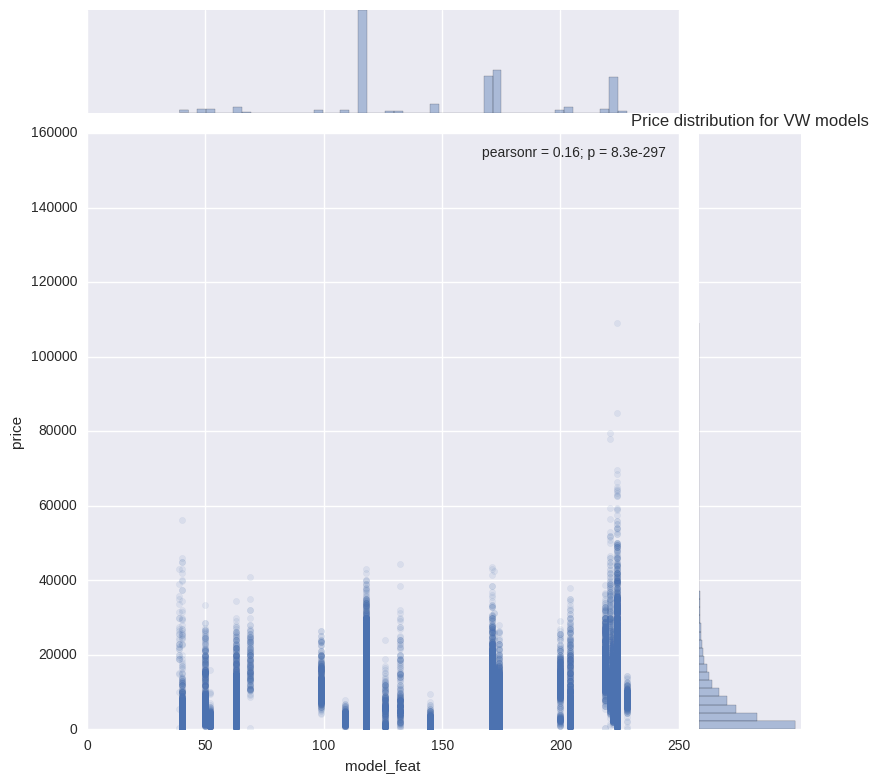

In [11]:
p = df_autos[df_autos['brand_feat']==37]
#plt.scatter(p['powerPS'], p['price'], alpha=.1, marker='o', color='b')
ax = sns.jointplot(x='model_feat', y='price',data=p[['model_feat','price']], alpha=0.1, size=8)
plt.title('Price distribution for VW models')
#plt.xlabel('Power in HP')
#plt.ylabel('Price (logarithmic)')
#plt.yscale('log')

model = zip(range(0, len(les['model'].classes_)), les['model'].classes_)

s = ''
for b in model:
    s = s + ' ' + str(b)

print("models: " + s)

#plt.xlim(0, 41)
plt.ylim(0, 160000)

Fuels:  (0, 'andere') (1, 'benzin') (2, 'cng') (3, 'diesel') (4, 'elektro') (5, 'hybrid') (6, 'lpg')
vehicleType:  (0, 'andere') (1, 'bus') (2, 'cabrio') (3, 'coupe') (4, 'kleinwagen') (5, 'kombi') (6, 'limousine') (7, 'suv')
gearbox:  (0, 'automatik') (1, 'manuell')
notRepairedDamage:  (0, 'ja') (1, 'nein')


(0, 160000)

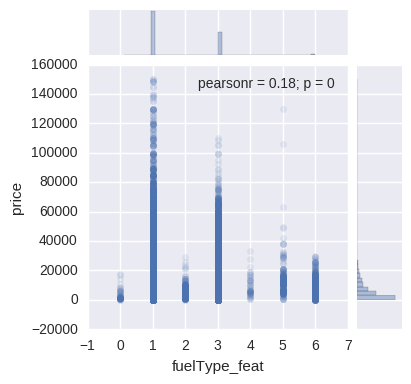

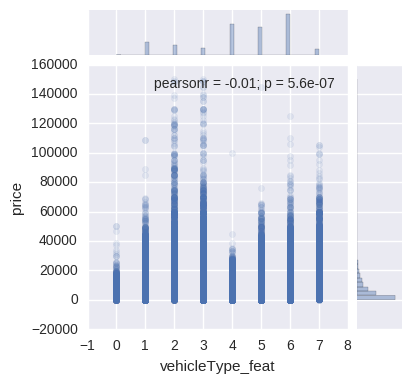

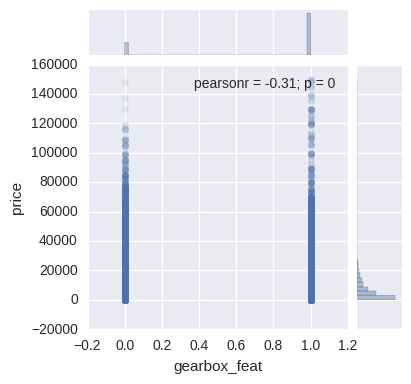

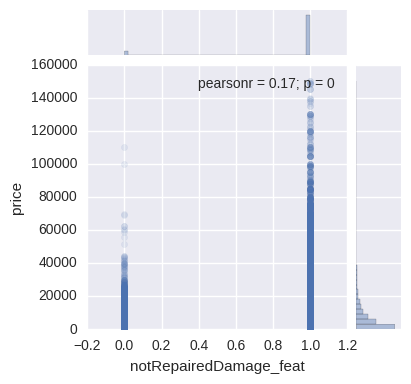

In [12]:
p = df_autos
f = plt.figure()

JG1 = sns.jointplot(x='fuelType_feat', y='price',data=p[['fuelType_feat','price']], alpha=0.1, size=4)
JG2 = sns.jointplot(x='vehicleType_feat', y='price',data=p[['vehicleType_feat','price']], alpha=0.1, size=4)
JG3 = sns.jointplot(x='gearbox_feat', y='price',data=p[['gearbox_feat','price']], alpha=0.1, size=4)
JG4 = sns.jointplot(x='notRepairedDamage_feat', y='price',data=p[['notRepairedDamage_feat','price']], alpha=0.1, size=4)

fuelTypes = zip(range(0, len(les['fuelType'].classes_)), les['fuelType'].classes_)
s = ''
for b in fuelTypes:
    s = s + ' ' + str(b)
print("Fuels: " + s)

vehicleTypes = zip(range(0, len(les['vehicleType'].classes_)), les['vehicleType'].classes_)
s = ''
for b in vehicleTypes:
    s = s + ' ' + str(b)
print("vehicleType: " + s)

gearboxes = zip(range(0, len(les['gearbox'].classes_)), les['gearbox'].classes_)
s = ''
for b in gearboxes:
    s = s + ' ' + str(b)
print("gearbox: " + s)

fuelTypes = zip(range(0, len(les['notRepairedDamage'].classes_)), les['notRepairedDamage'].classes_)
s = ''
for b in fuelTypes:
    s = s + ' ' + str(b)
print("notRepairedDamage: " + s)

#plt.xlim(0, 41)
plt.ylim(0, 160000)

## Correction

Transforming the right-skewed sale price column.


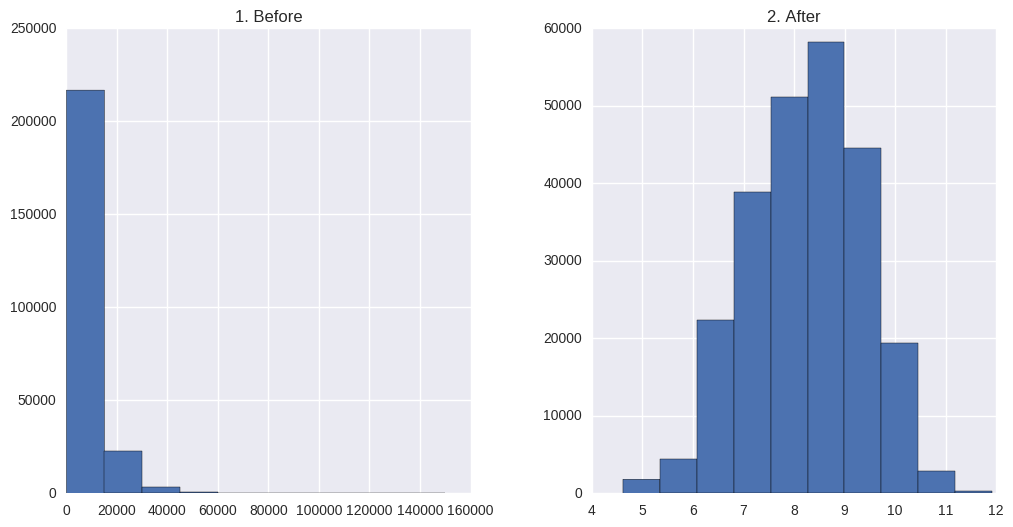

In [13]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"1. Before":Y, "2. After":np.log1p(Y)})
prices.hist()

Y = np.log1p(Y)

# Playing with different models

Trying with some model from scikit learn: LinearRegression, LR with L2 regularization and others.

In [14]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score, train_test_split


def cv_rmse(model, x, y):
    r = np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv = 5))
    return r

r = range(2003, 2017)
km_year = 10000



## Linear Regression

In [15]:
linear = linear_model.LinearRegression()

# Percent of the X array to use as training set. This implies that the rest will be test set
test_size = .2

#Split into train and validation
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state = 3)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
linear.fit(X_train, y_train)

# Explained variance score: 1 is perfect prediction
score = linear.score(X_test, y_test)
print('Variance score: %.2f' % score)

print("rmse on validation set", cv_rmse(linear, X_test, y_test).mean())


(195110, 10) (48778, 10) (195110,) (48778,)
Variance score: 0.68
rmse on validation set 0.639555427197


#### Predicting samples

[ 24547.88933013]
[ 28021.04561071]
[ 10082.71193557]
[ 23878.09002551]


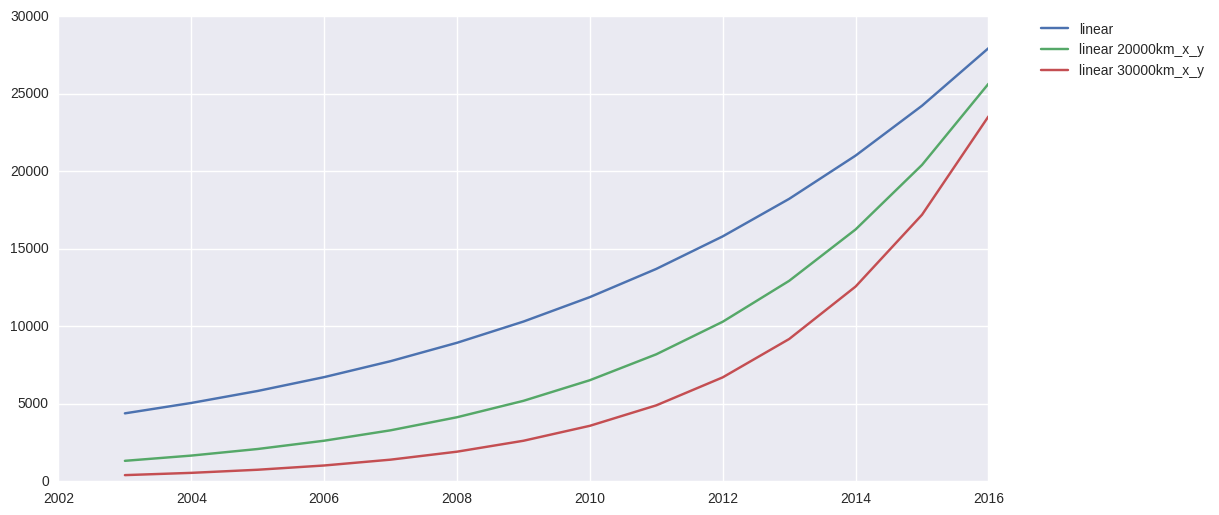

In [16]:

def calc_values(model, year, brand, car_model, vehicle, gearbox, fuel, powerPS, km, not_repaired_damage):
    sample = [year
          , powerPS
          , km
          , 1 # month
          , les['gearbox'].transform([gearbox])
          , les['notRepairedDamage'].transform([not_repaired_damage])
          , les['model'].transform([car_model])
          , les['brand'].transform([brand])
          , les['fuelType'].transform([fuel])
          , les['vehicleType'].transform([vehicle])]
    s_predict = np.expm1(model.predict([sample]))
    return s_predict

# [nan 'coupe' 'suv' 'kleinwagen' 'limousine' 'cabrio' 'bus' 'kombi' 'andere']
vw1 = calc_values(linear, 2016, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 105, 10000, 'nein')
bmw  = calc_values(linear, 2016, 'bmw', '3er', 'limousine', 'manuell', 'diesel', 150, 10000, 'nein')
fiat  = calc_values(linear, 2016, 'fiat', 'punto', 'kleinwagen', 'manuell', 'benzin', 60, 10000, 'nein')
vw2 = calc_values(linear, 2016, 'volkswagen', 'tiguan', 'suv', 'manuell', 'diesel', 130, 10000, 'nein')

print(vw1)
print(bmw)
print(fiat)
print(vw2)

values_linear  = [calc_values(linear, y, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 120, km_year * (2017-y), 'nein') for y in r]
values_linear2  = [calc_values(linear, y, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 120, km_year * 2 * (2017-y), 'nein') for y in r]
values_linear3  = [calc_values(linear, y, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 120, km_year * 3 * (2017-y), 'nein') for y in r]
plt.plot(r, values_linear, label='linear')
plt.plot(r, values_linear2, label='linear 20000km_x_y')
plt.plot(r, values_linear3, label='linear 30000km_x_y')

#plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


## L1 regularized LR


Variance score: 0.61
kilometer                -0.000009
monthOfRegistration       0.000000
gearbox_feat             -0.000000
notRepairedDamage_feat    0.000000
brand_feat                0.000000
fuelType_feat             0.000000
vehicleType_feat         -0.000000
model_feat                0.000232
powerPS                   0.009325
yearOfRegistration        0.049206
dtype: float64
0.707839916347
rmse on validation set 0.708803418524


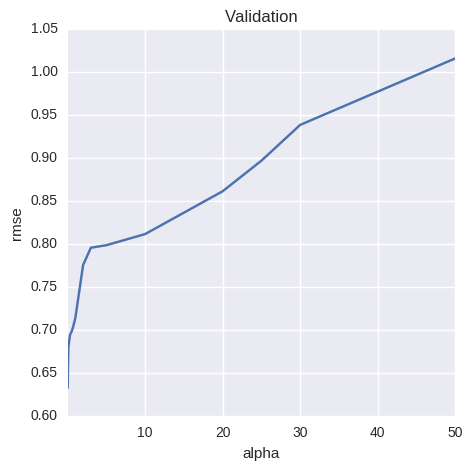

In [17]:

alphas = [0.005,0.05, 0.1, 0.3, 0.5, 0.7, 1, 2, 3, 5, 10, 20, 25, 30, 50]
cv_lasso = [cv_rmse(Lasso(alpha = alpha), X_train, y_train).mean() for alpha in alphas]

cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "Validation", figsize=(5,5))
plt.xlabel("alpha")
plt.ylabel("rmse")

model_lasso = Lasso(alpha = cv_lasso.min()).fit(X_train, y_train)

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % model_lasso.score(X_test, y_test))

coef = pd.Series(model_lasso.coef_, index = df_autos.iloc[:,1:].columns)

imp_coef = pd.concat([coef.sort_values()])

print(imp_coef)

print(np.sqrt(np.mean((y_test - model_lasso.predict(X_test))**2)))
print("rmse on validation set", cv_rmse(model_lasso, X_test, y_test).mean())


#### Predicting samples

[ 16610.43495931]
[ 24063.59282806]
[ 10804.11801494]
[ 20957.00514208]


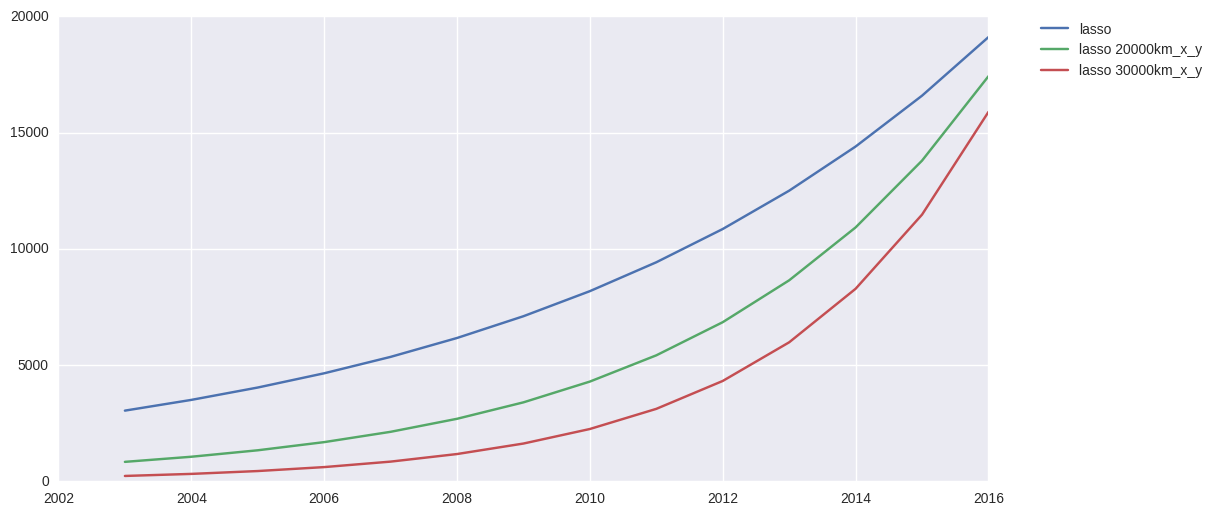

In [18]:
vw1 = calc_values(model_lasso, 2016, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 105, 10000, 'nein')
bmw  = calc_values(model_lasso, 2016, 'bmw', '3er', 'limousine', 'manuell', 'diesel', 150, 10000, 'nein')
fiat  = calc_values(model_lasso, 2016, 'fiat', 'punto', 'kleinwagen', 'manuell', 'benzin', 60, 10000, 'nein')
vw2 = calc_values(model_lasso, 2016, 'volkswagen', 'tiguan', 'suv', 'manuell', 'diesel', 130, 10000, 'nein')

print(vw1)
print(bmw)
print(fiat)
print(vw2)

values_lasso  = [calc_values(model_lasso, y, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 120, km_year * (2017-y), 'nein') for y in r]
values_lasso2  = [calc_values(model_lasso, y, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 120, km_year * 2 * (2017-y), 'nein') for y in r]
values_lasso3  = [calc_values(model_lasso, y, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 120, km_year * 3 * (2017-y), 'nein') for y in r]
plt.plot(r, values_lasso, label='lasso')
plt.plot(r, values_lasso2, label='lasso 20000km_x_y')
plt.plot(r, values_lasso3, label='lasso 30000km_x_y')

#plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


## L2 regularized LR

Variance score: 0.68
gearbox_feat             -0.062801
vehicleType_feat         -0.040712
model_feat               -0.000271
kilometer                -0.000009
brand_feat                0.003133
monthOfRegistration       0.005054
powerPS                   0.008632
yearOfRegistration        0.056789
fuelType_feat             0.151817
notRepairedDamage_feat    0.751482
dtype: float64
0.639334838313
rmse on validation set 0.639555431574


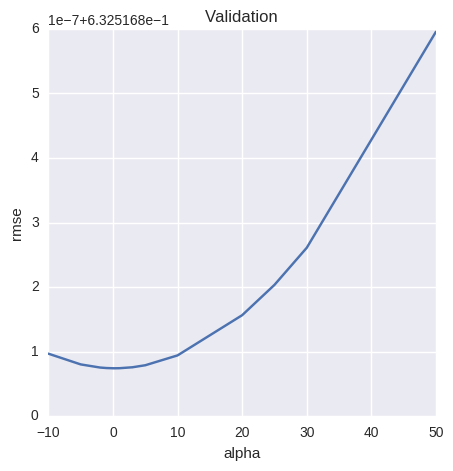

In [19]:

alphas = [-10, -5, -2, -1, 0, 0.005,0.05, 0.1, 0.3, 1, 3, 5, 10, 20, 25, 30, 50]
cv_ridge = [cv_rmse(Ridge(alpha = alpha), X_train, y_train).mean() for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation", figsize=(5,5))
plt.xlabel("alpha")
plt.ylabel("rmse")

model_ridge = Ridge(alpha = cv_ridge.min()).fit(X_train, y_train)

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % model_ridge.score(X_test, y_test))

coef = pd.Series(model_ridge.coef_, index = df_autos.iloc[:,1:].columns)

imp_coef = pd.concat([coef.sort_values()])

print(imp_coef)

print(np.sqrt(np.mean((y_test - model_ridge.predict(X_test))**2)))
print("rmse on validation set", cv_rmse(model_ridge, X_test, y_test).mean())


#### Predicting samples

[ 24547.87387523]
[ 28021.04106493]
[ 10082.7060047]
[ 23878.09077935]


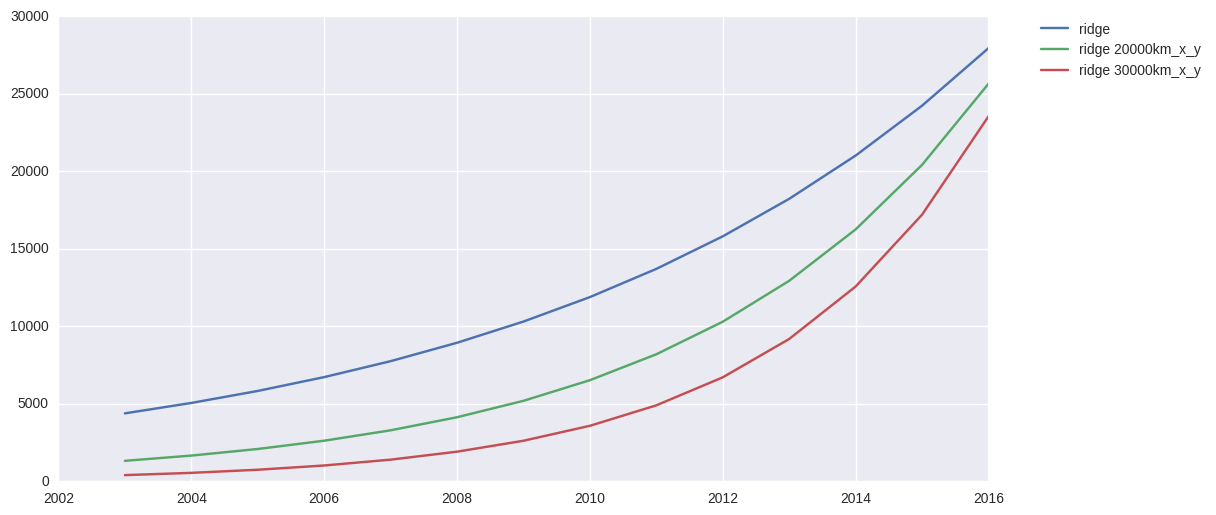

In [20]:
vw1 = calc_values(model_ridge, 2016, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 105, 10000, 'nein')
bmw  = calc_values(model_ridge, 2016, 'bmw', '3er', 'limousine', 'manuell', 'diesel', 150, 10000, 'nein')
fiat  = calc_values(model_ridge, 2016, 'fiat', 'punto', 'kleinwagen', 'manuell', 'benzin', 60, 10000, 'nein')
vw2 = calc_values(model_ridge, 2016, 'volkswagen', 'tiguan', 'suv', 'manuell', 'diesel', 130, 10000, 'nein')

print(vw1)
print(bmw)
print(fiat)
print(vw2)

values_ridge  = [calc_values(model_ridge, y, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 120, km_year * (2017-y), 'nein') for y in r]
values_ridge2  = [calc_values(model_ridge, y, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 120, km_year * 2 * (2017-y), 'nein') for y in r]
values_ridge3  = [calc_values(model_ridge, y, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 120, km_year * 3 * (2017-y), 'nein') for y in r]
plt.plot(r, values_ridge, label='ridge')
plt.plot(r, values_ridge2, label='ridge 20000km_x_y')
plt.plot(r, values_ridge3, label='ridge 30000km_x_y')

#plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


## Random forests

In [21]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators = 100)
forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [22]:
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % forest.score(X_test, y_test))

print(np.sqrt(np.mean((y_test - forest.predict(X_test))**2)))
print("rmse on validation set", cv_rmse(forest, X_test, y_test).mean())


Variance score: 0.88
0.391895988852
rmse on validation set 0.426248010639


#### Predicting samples

[ 25110.76893706]
[ 23023.27558459]
[ 8980.31497294]
[ 23516.84301772]


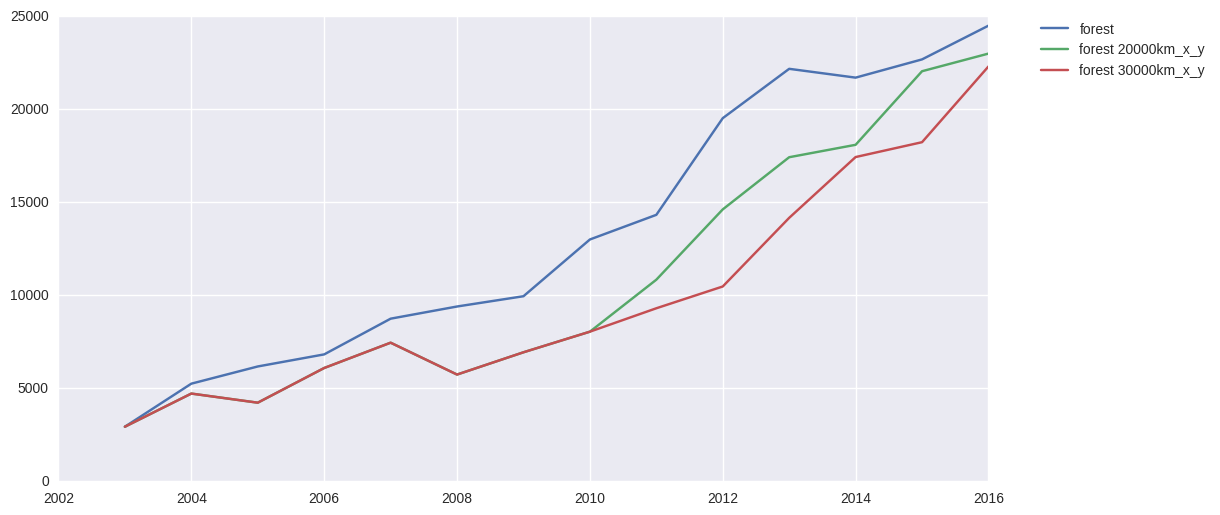

In [23]:
vw1 = calc_values(forest, 2016, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 105, 10000, 'nein')
bmw  = calc_values(forest, 2016, 'bmw', '3er', 'limousine', 'manuell', 'diesel', 150, 10000, 'nein')
fiat  = calc_values(forest, 2016, 'fiat', 'punto', 'kleinwagen', 'manuell', 'benzin', 60, 10000, 'nein')
vw2 = calc_values(forest, 2016, 'volkswagen', 'tiguan', 'suv', 'manuell', 'diesel', 130, 10000, 'nein')

print(vw1)
print(bmw)
print(fiat)
print(vw2)

values_forest = [calc_values(forest     , y, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 120, km_year * (2017-y), 'nein') for y in r]
values_forest2 = [calc_values(forest     , y, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 120, km_year* 2 * (2017-y), 'nein') for y in r]
values_forest3 = [calc_values(forest     , y, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 120, km_year* 3 * (2017-y), 'nein') for y in r]

plt.plot(r, values_forest, label='forest')
plt.plot(r, values_forest2, label='forest 20000km_x_y')
plt.plot(r, values_forest3, label='forest 30000km_x_y')

#plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


## Testing XGBoost

In [24]:
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

clf = XGBRegressor()
clf.fit(X_train, y_train)


XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

0.433305159267


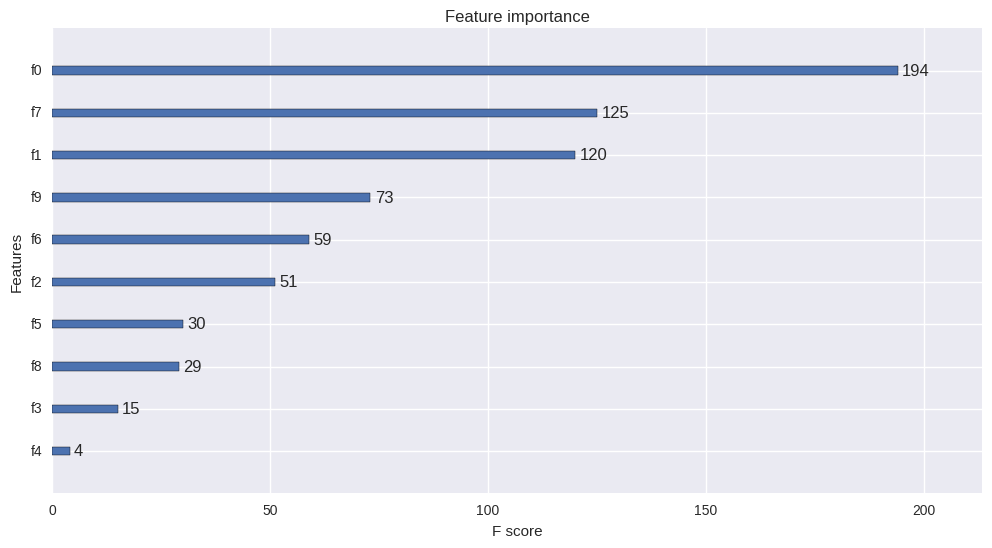

In [25]:
xgb.plot_importance(clf)

#f0 = year
#f1 = powerPS
#f2 = km
#f3 = month
#f4 = gearbox
#f5 = notRepairedDamage
#f6 = model
#f7 = brand
#f8 = fuelType
#f9 = vehicleType

# make predictions for test data
y_pred = clf.predict(X_test)
print(np.sqrt(np.mean((y_test - y_pred)**2)))


#### Predicting samples

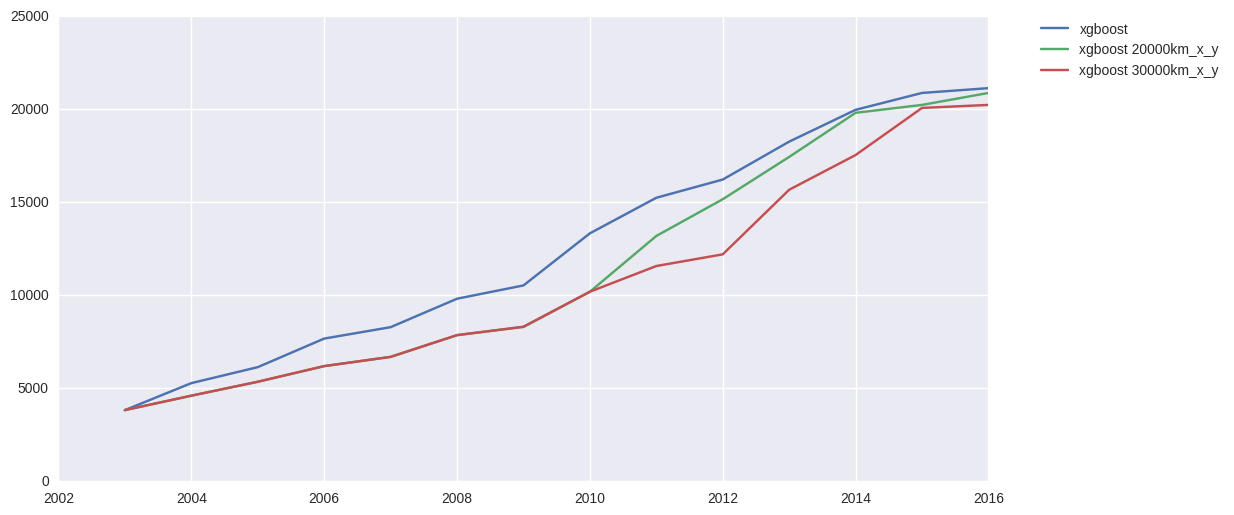

In [26]:
values_clf  = [calc_values(clf, y, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 115, km_year * (2017-y), 'nein') for y in r]
values_clf2 = [calc_values(clf, y, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 115, km_year * 2 * (2017-y), 'nein') for y in r]
values_clf3 = [calc_values(clf, y, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 115, km_year * 3 * (2017-y), 'nein') for y in r]
plt.plot(r, values_clf , label='xgboost')
plt.plot(r, values_clf2, label='xgboost 20000km_x_y')
plt.plot(r, values_clf3, label='xgboost 30000km_x_y')

#plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


# Conclusions

I've tried to play with as much stuff as I could with this dataset in order to understand the very basic topics about:

* data interpretation and selection
* feature selection and labeling
* data visualization
* very rough ML algorithms application

There's very much to improve both in how I managed all these steps and in the different outcomes of the predictions on the sell price. I'll experiment a bit more in the next few days, then I'll move on another dataset to learn more.
